In [1]:
"""
This is an conditional flow and does now consider the aux features
ATTEMPT TO USE Flows
https://github.com/bayesiains/nflows

still need to make use of the auxiliary features like this:
https://github.com/bayesiains/nflows/blob/master/examples/conditional_moons.ipynb

https://arxiv.org/abs/1908.05164
"""

'\nThis is an conditional flow and does now consider the aux features\nATTEMPT TO USE Flows\nhttps://github.com/bayesiains/nflows\n\nstill need to make use of the auxiliary features like this:\nhttps://github.com/bayesiains/nflows/blob/master/examples/conditional_moons.ipynb\n\nhttps://arxiv.org/abs/1908.05164\n'

In [2]:
# uncomment to use specific GPU device
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=3

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, QuantileTransformer

#import keras
#import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
from IPython.display import clear_output
%matplotlib inline
from matplotlib.colors import LogNorm

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal, ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedUMNNAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet

import tqdm
from tqdm import trange
import time
import math

In [5]:
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
dev

'cuda:0'

## 1. Prepare the data

read the data from csv file:

In [6]:
CSV_PATH = "./data/data_for_gan_combined_ksttrain.csv"
PID_NAME = "e"

In [7]:
data_all_pids = pd.read_csv(CSV_PATH)

split columns in data to categories

In [8]:
vars_list = list(data_all_pids)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

In [9]:
in_columns = ['S6aux0','S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = vars_list_input
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)
MODEL_NAME = "Flow_Kramer_pid{}_ksttrain_nspdgauss".format(PID_NAME)
MODEL_WEIGHTS_FILE = "./weights/%s.pt" % MODEL_NAME

In [10]:
BATCH_SIZE = int(1e4)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.3

In [11]:
def split_and_scale(data, robust_scaler=None, maxabs_scaler=None, gauss_scaler=None):
    # split data to train, val & test
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    
    # dropping pid column for applying preprocessing, will return it after
    pid_train = np.array(data_train["pid"])
    pid_val = np.array(data_val["pid"])
    pid_test = np.array(data_test["pid"])
    
    data_train.drop("pid", axis=1, inplace=True)
    data_val.drop("pid", axis=1, inplace=True)
    data_test.drop("pid", axis=1, inplace=True)
    
    # path to save preprocessor models to
    if not os.path.exists('gan_preprocessors'):
        os.makedrs('gan_preprocessors')
    
    """
    # applying robust scaler
    if robust_scaler is None:
        robust_scaler = RobustScaler().fit(data_train)
        # save preprocessor model
        joblib.dump(robust_scaler, os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl")
        
    data_train = pd.DataFrame(robust_scaler.transform(data_train.values),
                              columns=data_train.columns)
    data_val = pd.DataFrame(robust_scaler.transform(data_val.values),
                            columns=data_val.columns)
    data_test = pd.DataFrame(robust_scaler.transform(data_test.values),
                            columns=data_test.columns)
    """
    
    """
    # applying max abs scaler
    if maxabs_scaler is None:
        maxabs_scaler = MaxAbsScaler().fit(data_train)
        # save preprocessor model
        joblib.dump(maxabs_scaler, os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
        
    data_train = pd.DataFrame(maxabs_scaler.transform(data_train),
                              columns=data_train.columns)
    data_val = pd.DataFrame(maxabs_scaler.transform(data_val),
                            columns=data_val.columns)
    data_test = pd.DataFrame(maxabs_scaler.transform(data_test),
                            columns=data_test.columns)
    """
    
    # applying max abs scaler
    if gauss_scaler is None:
        gauss_scaler = QuantileTransformer(output_distribution='normal').fit(data_train)
        # save preprocessor model
        joblib.dump(gauss_scaler, os.path.join('gan_preprocessors', MODEL_NAME) + "_gauss_preprocessor.pkl")
        
    data_train = pd.DataFrame(gauss_scaler.transform(data_train),
                              columns=data_train.columns)
    data_val = pd.DataFrame(gauss_scaler.transform(data_val),
                            columns=data_val.columns)
    data_test = pd.DataFrame(gauss_scaler.transform(data_test),
                            columns=data_test.columns)
    
    # get back pid column
    data_train["pid"] = pid_train
    data_val["pid"] = pid_val
    data_test["pid"] = pid_test
    
    return data_train, data_val, data_test, robust_scaler, max_abs_scaler, gauss_scaler

In [12]:
# leave only data corresponding to one PID that we will build GAN for
data_pid = data_all_pids[data_all_pids.pid == PID_NAME]
try:
    robust_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl") 
    max_abs_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
    gauss_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_gauss_preprocessor.pkl")
    
except:
    robust_scaler, max_abs_scaler = None, None
    gauss_scaler = None
data_train, data_val, data_test, robust_scaler, max_abs_scaler, gauss_scaler = split_and_scale(data_pid, robust_scaler, max_abs_scaler, gauss_scaler)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
# don't need this for GAN
data_train.drop("pid", axis=1, inplace=True)
data_val.drop("pid", axis=1, inplace=True)
data_test.drop("pid", axis=1, inplace=True)

In [14]:
aux_columns = vars_list_aux

Let's look at the distributions of the features:

In [15]:
def plot_1D_projctn(x_val, val_generated, label1="data", label2="generated", title=""):
    fig, axes = plt.subplots(1, 3, figsize=(3*5, 5))
    for INDEX, ax in zip((0, 1, 2), axes):
        #_, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
        _, bins, _ = ax.hist(x_val[:, INDEX], bins=100, label=label1, density=True)
        ax.hist(val_generated[:, INDEX], bins=bins, label=label2, alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX]+ title )
    plt.show()

In [16]:
def plot_2D_projctn(x_val, test_generated=None, PLOTNOZOOM=False, nbins=50):
    #x_val = data_val[out_columns].to_numpy()

    if test_generated is None:
        fig, ax = plt.subplots(nrows=1, ncols=3)
        h1 = ax[0].hist2d(x_val[:, 0], x_val[:, 1], bins=nbins, norm=LogNorm())
        h2 = ax[1].hist2d(x_val[:, 0], x_val[:, 2], bins=nbins, norm=LogNorm())
        h3 = ax[2].hist2d(x_val[:, 1], x_val[:, 2], bins=nbins, norm=LogNorm())
        
        ax[0].set_xlabel("0"); ax[0].set_ylabel("1")
        ax[1].set_xlabel("0"); ax[1].set_ylabel("2")
        ax[2].set_xlabel("1"); ax[2].set_ylabel("2")
        fig.colorbar(h3[3], ax=ax)

        print("Ground truth")
        plt.show()


    if test_generated is not None: 
        """
        x_val = test_generated
        fig, ax = plt.subplots(nrows=1, ncols=3)
        h1 = ax[0].hist2d(x_val[:, 0], x_val[:, 1], bins=50, norm=LogNorm(), range=bin0 )
        h2 = ax[1].hist2d(x_val[:, 0], x_val[:, 2], bins=50, norm=LogNorm(), range=bin1 )
        h3 = ax[2].hist2d(x_val[:, 1], x_val[:, 2], bins=50, norm=LogNorm(), range=bin2 )
        fig.colorbar(h[3], ax=ax)
        """
        fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(7*2.5, 5))
        h4 = ax[4].hist2d(x_val[:, 0], x_val[:, 1], bins=nbins, norm=LogNorm(), density=True)
        h5 = ax[5].hist2d(x_val[:, 0], x_val[:, 2], bins=nbins, norm=LogNorm(), density=True)
        h6 = ax[6].hist2d(x_val[:, 1], x_val[:, 2], bins=nbins, norm=LogNorm(), density=True)
        
        ax[4].set_xlabel("0"); ax[4].set_ylabel("1")
        ax[5].set_xlabel("0"); ax[5].set_ylabel("2")
        ax[6].set_xlabel("1"); ax[5].set_ylabel("2")
        
        bin0 = np.array([ax[4].get_xlim(), ax[4].get_ylim()])
        bin1 = np.array([ax[5].get_xlim(), ax[5].get_ylim()])
        bin2 = np.array([ax[6].get_xlim(), ax[6].get_ylim()])
        
        h1 = ax[0].hist2d(test_generated[:, 0], test_generated[:, 1], bins=nbins, norm=LogNorm(), range=bin0, density=True )
        h2 = ax[1].hist2d(test_generated[:, 0], test_generated[:, 2], bins=nbins, norm=LogNorm(), range=bin1, density=True )
        h3 = ax[2].hist2d(test_generated[:, 1], test_generated[:, 2], bins=nbins, norm=LogNorm(), range=bin2, density=True )
        
        ax[0].set_xlabel("0"); ax[0].set_ylabel("1")
        ax[1].set_xlabel("0"); ax[1].set_ylabel("2")
        ax[2].set_xlabel("1"); ax[2].set_ylabel("2")
        
        fig.colorbar(h6[3], ax=ax)
        

        print("Generated Vs Truth")
        plt.show()
        
        if PLOTNOZOOM:
            x_val = test_generated
            fig, ax = plt.subplots(nrows=1, ncols=3)
            h1 = ax[0].hist2d(x_val[:, 0], x_val[:, 1], bins=nbins, norm=LogNorm() )
            h2 = ax[1].hist2d(x_val[:, 0], x_val[:, 2], bins=nbins, norm=LogNorm() )
            h3 = ax[2].hist2d(x_val[:, 1], x_val[:, 2], bins=nbins, norm=LogNorm() )
            
            ax[0].set_xlabel("0"); ax[0].set_ylabel("1")
            ax[1].set_xlabel("0"); ax[1].set_ylabel("2")
            ax[2].set_xlabel("1"); ax[2].set_ylabel("2")
            fig.colorbar(h3[3], ax=ax)

            print("Generated truth No Zoom")
            plt.show()

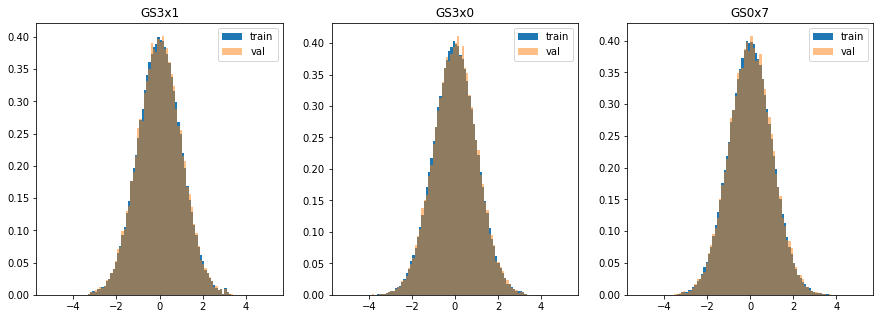

In [17]:
plot_1D_projctn(data_train[vars_list_input].values,data_val[vars_list_input].values, "train", "val")

Ground truth


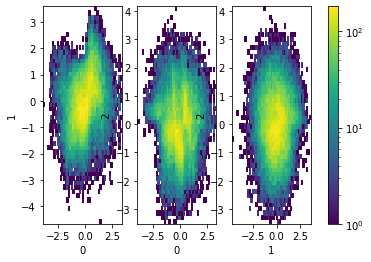

In [18]:
plot_2D_projctn(data_val[out_columns].to_numpy())

In [19]:
corr = np.corrcoef(data_train[vars_list_input].values.T)
corr

array([[1.        , 0.28999858, 0.02930947],
       [0.28999858, 1.        , 0.00899967],
       [0.02930947, 0.00899967, 1.        ]])

## 2. Building GAN

In [20]:
# rearrange columns to make them be in similar order
data_train = data_train[in_columns+out_columns]
data_val = data_val[in_columns+out_columns]
data_test = data_test[in_columns+out_columns]

In [21]:
context_encoder = nn.Sequential(
          nn.Linear(len(in_columns), 2*len(in_columns)),
          nn.ReLU(),
          nn.Linear(2*len(in_columns), 2*len(in_columns)),
          nn.ReLU(),
          nn.Linear(2*len(in_columns), 2*len(out_columns))
        )

In [22]:
num_layers = 5
#context_encoder=nn.Linear(len(in_columns), 2*len(out_columns))
#context_encoder = Net(len(in_columns), 2*len(out_columns))

base_dist = ConditionalDiagonalNormal(shape=[len(out_columns)], 
                                      context_encoder=context_encoder) 
#the output is the means and std devs in each of the dimensions of out_columns
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=len(out_columns)))
    #transforms.append(MaskedAffineAutoregressiveTransform(features=len(out_columns), 
    #                                                      hidden_features=6, 
    #                                                      context_features=len(in_columns)))
    transforms.append(MaskedUMNNAutoregressiveTransform(features=len(out_columns), 
                                                          hidden_features=10, 
                                                          context_features=len(in_columns)))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)
optimizer = optim.Adam(flow.parameters())

In [23]:
class DatasetNumpy:
    def __init__(self, arr, arr_context=None):
        self.arr = arr
        self.arr_context = arr_context
        self.bool_context = not(arr_context is None)
        self.size = arr.shape[0]
        if self.bool_context: assert arr_context.shape[0]==arr.shape[0], "both arrays must be of the same size"
        self.nsampled = 0
        self.epoch = 0 
        
    def get_data(self, batch_size):
        if (batch_size+ self.nsampled) >= self.size:
            self.epoch +=1
            res = self.arr[self.nsampled:, :].copy()
            if self.bool_context: 
                res_context = self.arr_context[self.nsampled:, :].copy()
                shuffler = np.random.permutation(self.size)
                self.arr = self.arr[shuffler]
                self.arr_context = self.arr_context[shuffler]
                self.nsampled = 0
                return res, res_context
            else:
                np.random.shuffle(self.arr)
                self.nsampled = 0
                return res
            
            
        else:
            if self.bool_context: 
                res = self.arr[self.nsampled:(self.nsampled+batch_size), :]
                res_context = self.arr_context[self.nsampled:(self.nsampled+batch_size), :]
                self.nsampled += batch_size
                return res, res_context
            else:
                res = self.arr[self.nsampled:(self.nsampled+batch_size), :]
                self.nsampled += batch_size
                return res
        
    def get_array(self):
        return self.arr
    
    def get_epoch(self):
        return self.epoch

"""
Test with 
arr = np.array([range(10)]*2).T
arr_context = np.array([range(10)]*2).T
ds = DatasetNumpy(arr, arr_context)
ds.get_data(15)
ds.get_epoch()
"""

'\nTest with \narr = np.array([range(10)]*2).T\narr_context = np.array([range(10)]*2).T\nds = DatasetNumpy(arr, arr_context)\nds.get_data(15)\nds.get_epoch()\n'

In [24]:
print(len(out_columns), len(in_columns))

3 6


## 3. Training Flow

Number of data points :  (135373, 3)


batches:  10%|▉         | 69/700 [00:12<01:45,  6.00it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 5	 Sum Corrs 6.59e+00 	Loss 3.92e+00

Generated Vs Truth


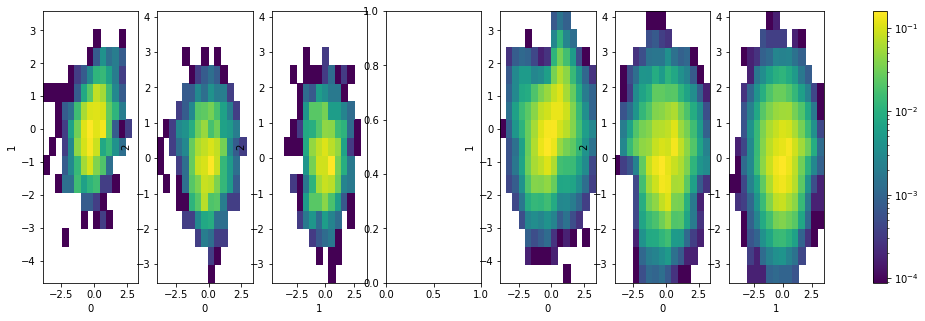

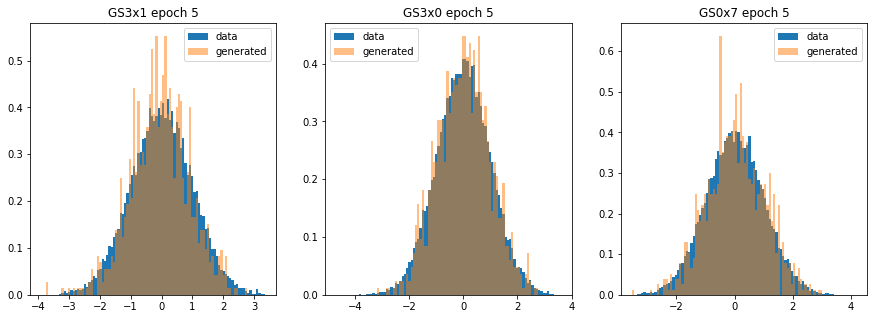

batches:  20%|█▉        | 139/700 [00:27<01:32,  6.04it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 10	 Sum Corrs 3.69e+00 	Loss 3.69e+00

Generated Vs Truth


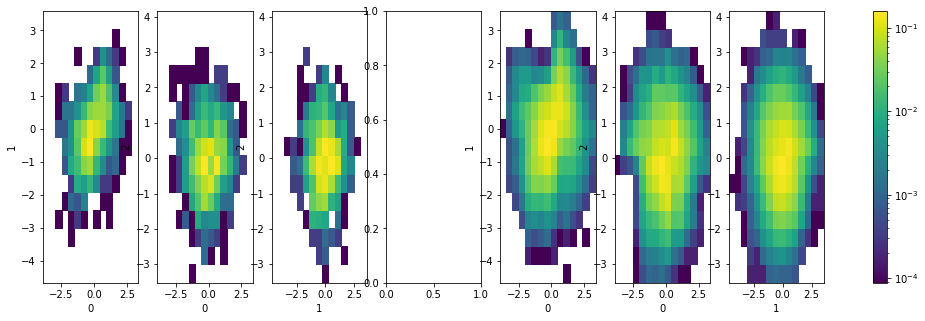

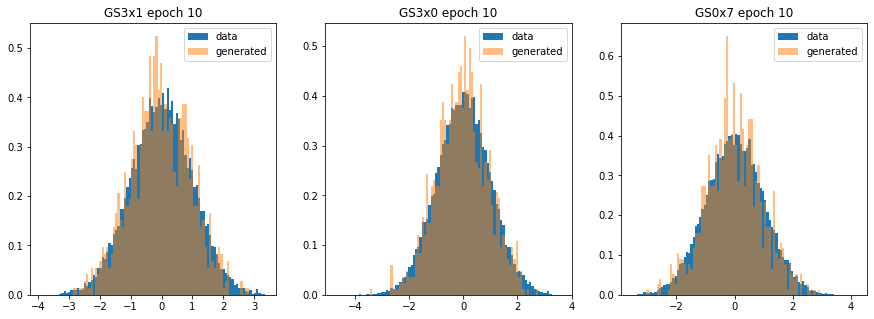

batches:  30%|██▉       | 209/700 [00:44<01:25,  5.76it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 15	 Sum Corrs 6.96e+00 	Loss 3.55e+00

Generated Vs Truth


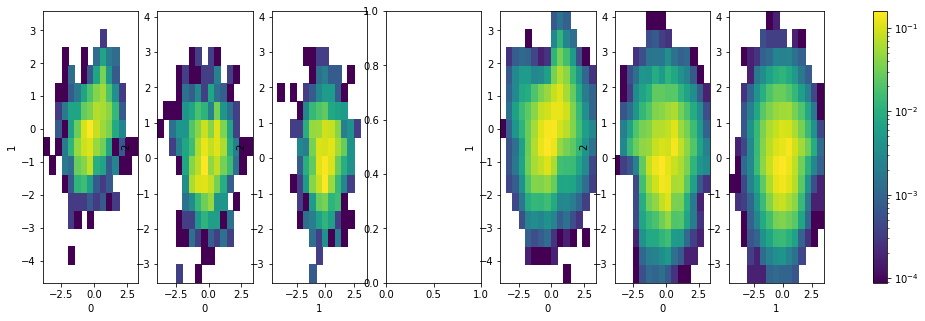

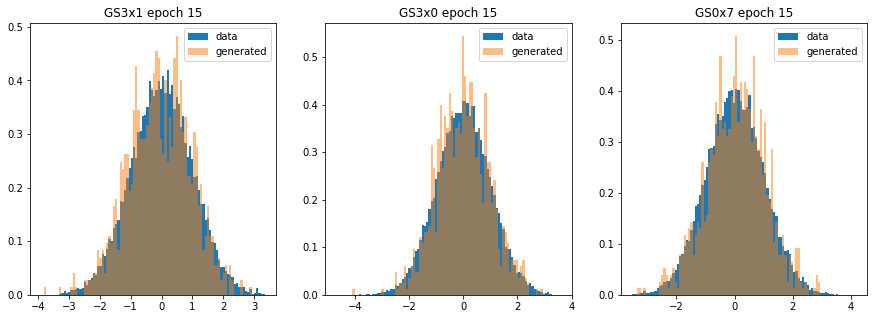

batches:  40%|███▉      | 279/700 [01:02<01:14,  5.65it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 20	 Sum Corrs 8.58e+00 	Loss 3.48e+00

Generated Vs Truth


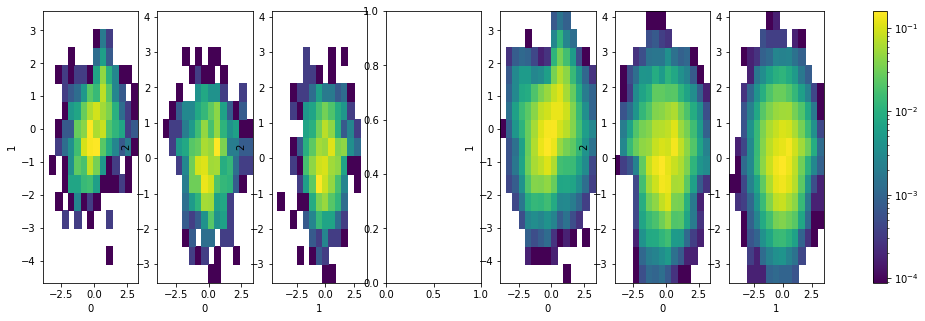

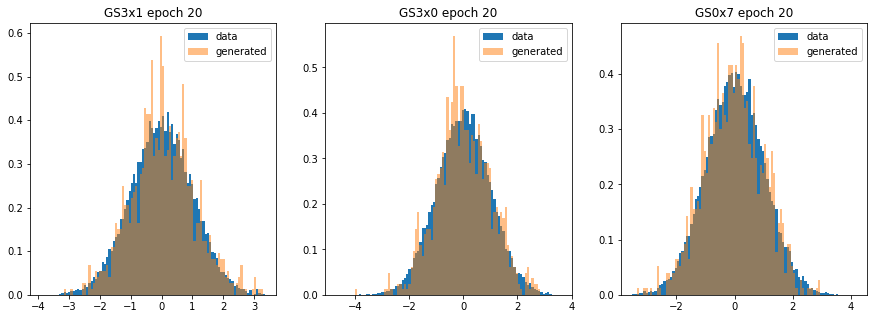

batches:  50%|████▉     | 349/700 [01:18<00:58,  6.02it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 25	 Sum Corrs 9.19e+00 	Loss 3.46e+00

Generated Vs Truth


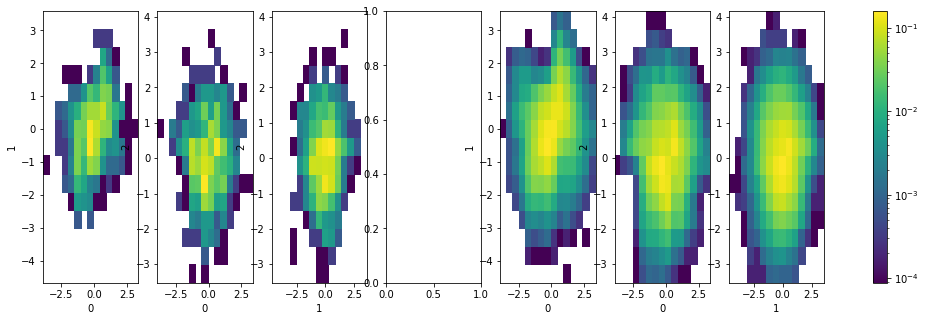

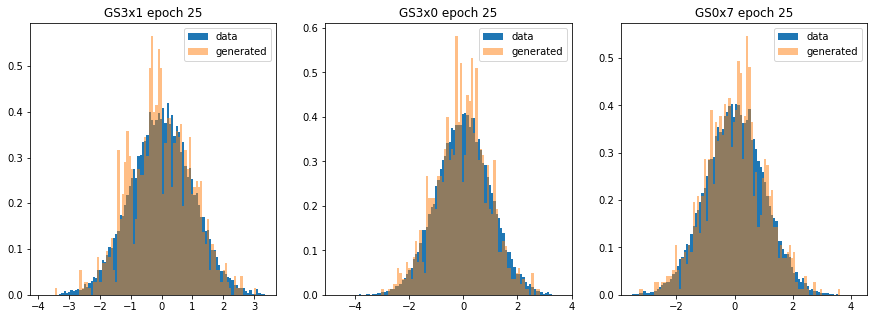

batches:  60%|█████▉    | 419/700 [01:33<00:46,  6.07it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 30	 Sum Corrs 4.94e+00 	Loss 3.43e+00

Generated Vs Truth


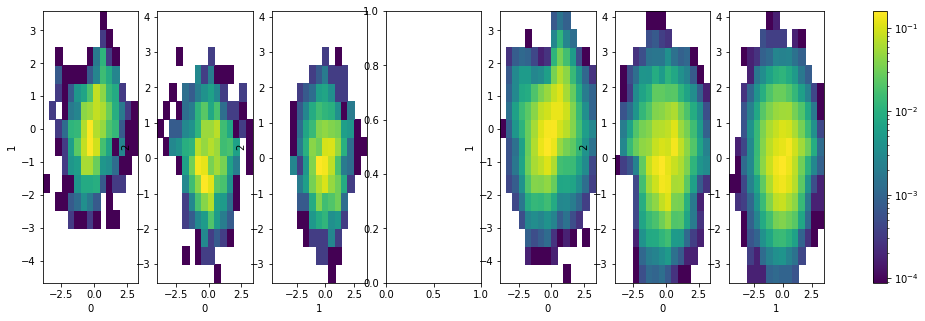

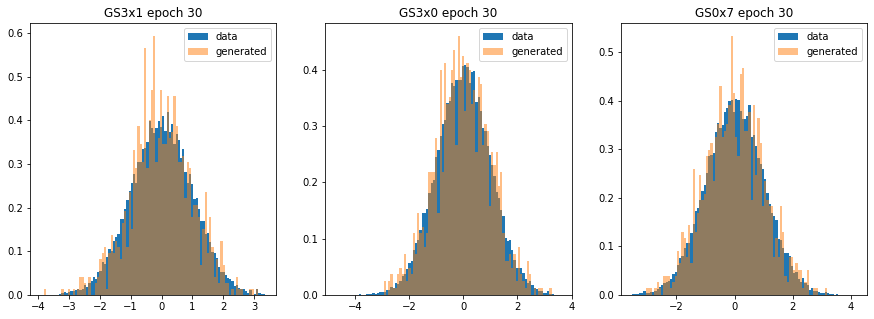

batches:  70%|██████▉   | 489/700 [01:49<00:35,  5.91it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 35	 Sum Corrs 1.90e+00 	Loss 3.39e+00

Generated Vs Truth


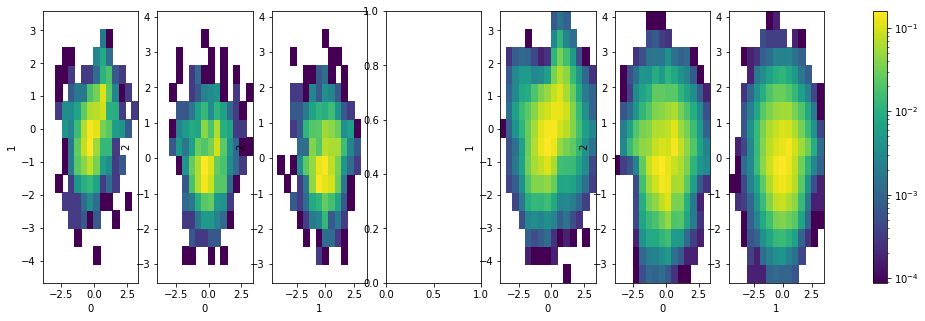

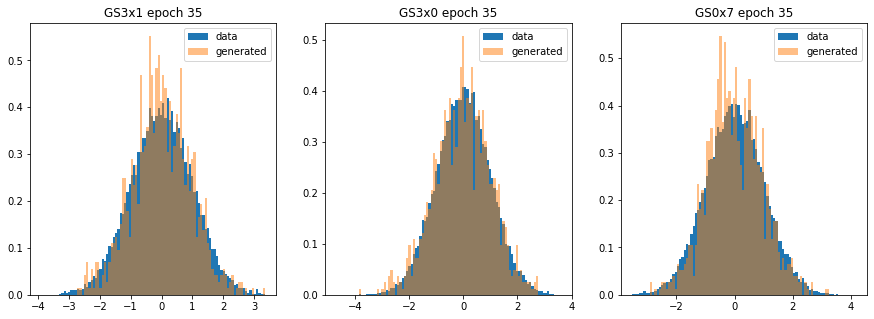

batches:  80%|███████▉  | 559/700 [02:07<00:24,  5.83it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 40	 Sum Corrs 5.68e+00 	Loss 3.44e+00

Generated Vs Truth


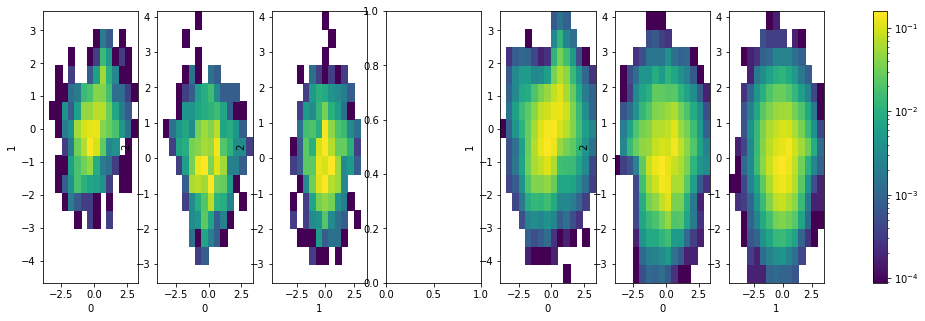

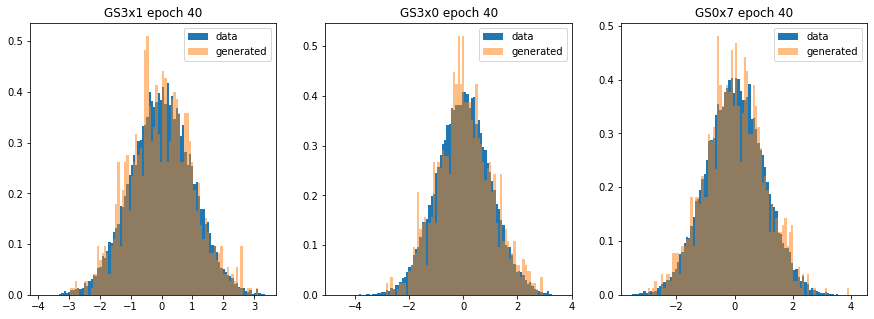

batches:  90%|████████▉ | 629/700 [02:24<00:12,  5.86it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 45	 Sum Corrs 3.19e+00 	Loss 3.39e+00

Generated Vs Truth


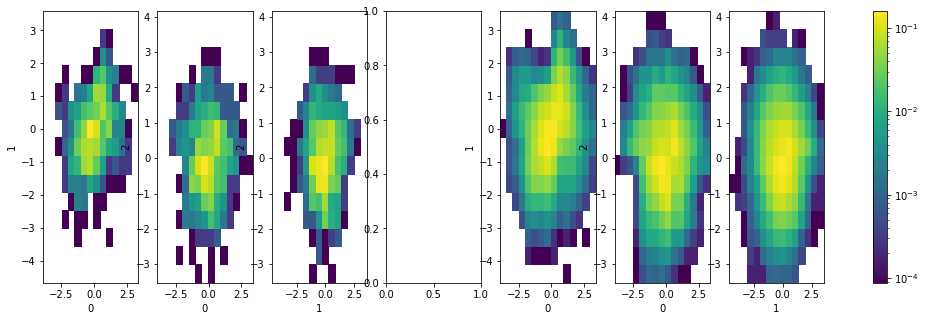

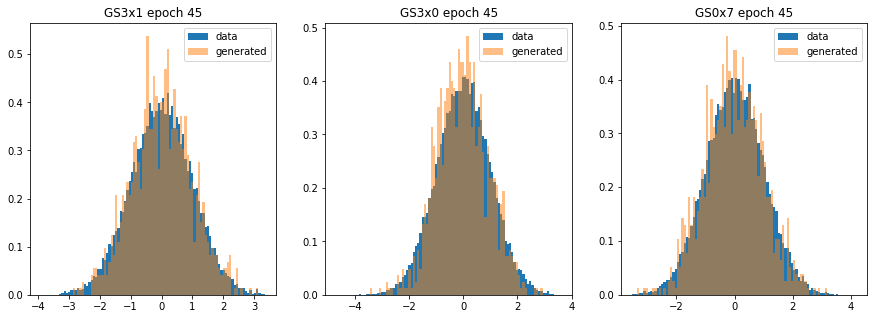

batches: 100%|█████████▉| 699/700 [02:41<00:00,  5.23it/s]

before sample
after sample

 ________________________________________________________________________________ 
Epoch 50	 Sum Corrs 1.57e+01 	Loss 3.40e+00

Generated Vs Truth


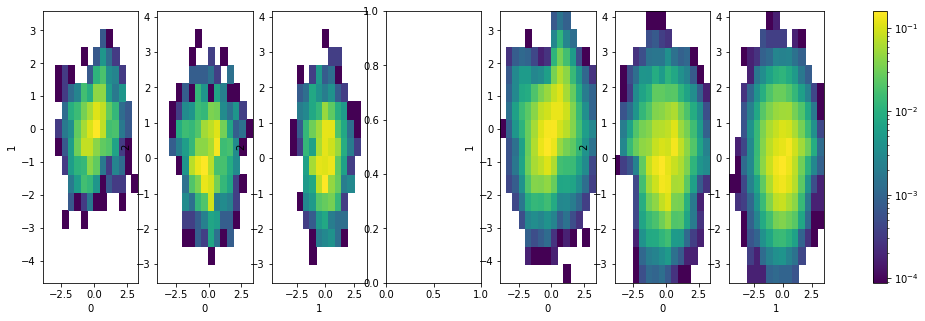

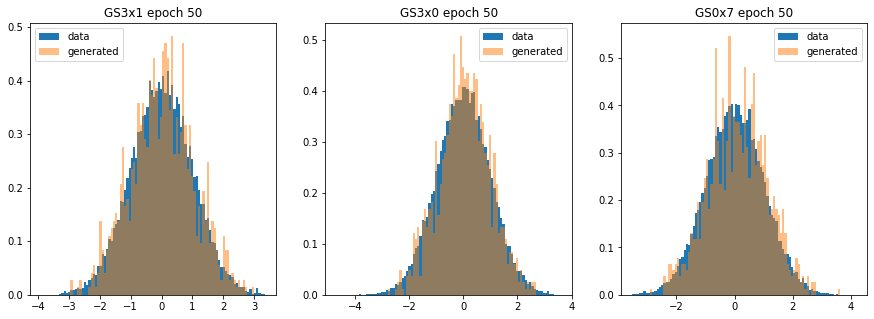

batches: 100%|██████████| 700/700 [02:46<00:00,  4.20it/s]


In [25]:
train_data_saved = data_train[out_columns].to_numpy()
train_data_saved_context = data_train[in_columns].to_numpy()
#np.save("train_data_saved.npy",train_data_saved)

ds = DatasetNumpy(train_data_saved[:,:], train_data_saved_context[:,:])
print("Number of data points : ", train_data_saved[:,:].shape)


nepochs = 50
#nsamplesperepoch = 10000 # There are 130k training examples
nsamplesperepoch = train_data_saved.shape[0]
nperbatch = 10000
nepochtoplot = 5 #number of batches until we sample from the flow and plot the results
nvals = int(1000) #number of data points to sample from flow

nbatchperepoch = math.ceil(nsamplesperepoch*1./nperbatch)
niters = int(nepochs*nbatchperepoch)
nbatchtoplot = int(nepochtoplot*nbatchperepoch)


x_val = data_val[out_columns].to_numpy()
x_val_context = data_val[in_columns].to_numpy()
context_val = torch.tensor(x_val_context[:nvals, :], dtype=torch.float32).to(device)


for i in trange(niters, desc='batches'): 
    #x, y = make_examples(500) #datasets.make_moons(500, noise=.1)
    #x = train_data_saved[:,1:]
    x, y = ds.get_data(nperbatch)
    x = torch.tensor(x, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % nbatchtoplot == 0:
        
        print("before sample")
        #make sure you sample only once for each context example
        val_generated = flow.sample(1, context=context_val).cpu().numpy().reshape((nvals,-1))
        print("after sample")
        
        corr_FLOW_val = np.corrcoef(val_generated.T)
        corr_diff_val =abs((corr - corr_FLOW_val)/corr)
        sum_corr_diff_val = sum(sum(corr_diff_val))
        print("\n","_"*80,"\nEpoch {}\t Sum Corrs {:.2e}".format(ds.get_epoch(), sum_corr_diff_val), "\tLoss {:.2e}\n".format(loss))
        
        plot_2D_projctn(x_val,val_generated, nbins=15)
        plot_1D_projctn(x_val,val_generated, "data", "generated", " epoch {}".format(ds.get_epoch()))
        
        
        #if not os.path.exists('plots'):
        #    os.makedirs('plots')
        #fig.savefig('./plots/{}.png'.format(MODEL_NAME))

In [26]:
print("Number of iterations trained {}".format(i))

Number of iterations trained 699


In [27]:
torch.save(flow, MODEL_WEIGHTS_FILE)

In [28]:
flowbest = torch.load(MODEL_WEIGHTS_FILE)
flowbest.eval()

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): ReversePermutation()
      (1): MaskedUMNNAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=3, out_features=10, bias=True)
          (context_layer): Linear(in_features=6, out_features=10, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (context_layer): Linear(in_features=6, out_features=10, bias=True)
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=10, out_features=10, bias=True)
                (1): MaskedLinear(in_features=10, out_features=10, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): MaskedResidualBlock(
              (context_layer): Linear(in_features=6, out_features=10, bias=True)
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=10, out_fe

After training, let's check distribution generated by GAN for test examples:

before sample
after sample

 ________________________________________________________________________________ 
 Sum Corrs 2.89e+00 
 ________________________________________________________________________________


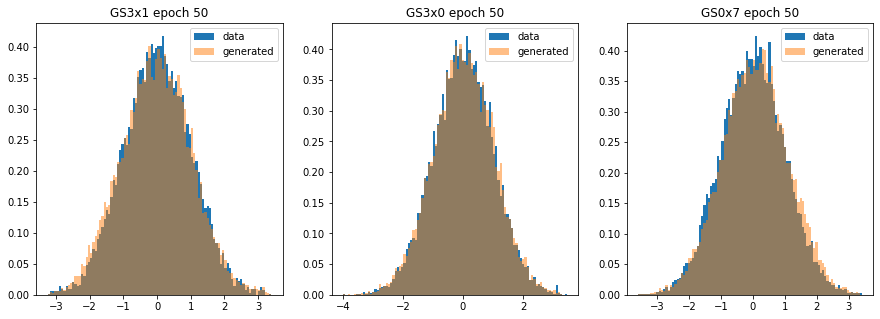

Generated Vs Truth


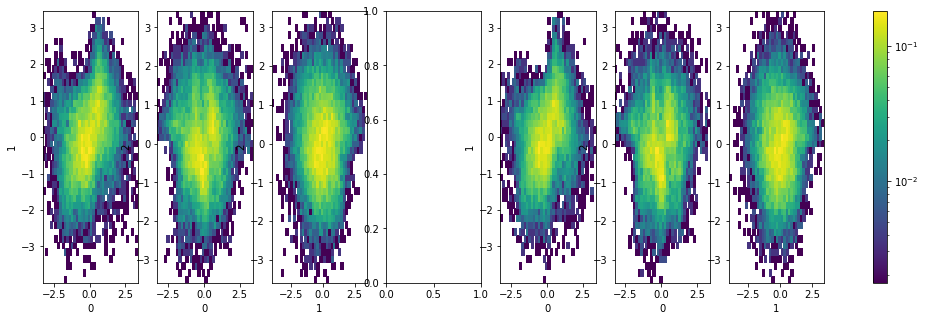

In [29]:
x_test = data_test[out_columns].to_numpy()
x_test_context = data_test[in_columns].to_numpy() 
context_test = torch.tensor(x_test_context, dtype=torch.float32).to(device)

print("before sample")
#make sure you sample only once for each context example
test_generated = flowbest.sample(1, context=context_test).cpu().numpy().reshape((x_test.shape[0],-1))
print("after sample")

corr = np.corrcoef(data_train[vars_list_input].values.T)
corr_FLOW = np.corrcoef(test_generated.T)
corr_diff =abs((corr - corr_FLOW)/corr)
sum_corr_diff = sum(sum(corr_diff))

print("\n","_"*80,"\n","Sum Corrs {:.2e}".format(sum_corr_diff), "\n", "_"*80)

plot_1D_projctn(x_test,test_generated, "data", "generated", " epoch {}".format(ds.get_epoch()))
plot_2D_projctn(x_test,test_generated, nbins=40)



## 4. Save GAN weights and generated test data

In [30]:
print(MODEL_NAME)
try:
    #robust_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl") 
    #max_abs_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
    gauss_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_gauss_preprocessor.pkl")
except: print("fail")

Flow_Kramer_pide_ksttrain_nspdgauss


In [31]:
gauss_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_gauss_preprocessor.pkl")

apply inverse transformations of the preprocessors on GAN output on test data:

In [32]:
#test_transformed = max_abs_scaler.inverse_transform(np.concatenate([data_pid[vars_list_aux][:len(test_generated)].values, test_generated], axis=1))
#test_transformed = robust_scaler.inverse_transform(test_transformed)
test_transformed = gauss_scaler.inverse_transform(np.concatenate([data_pid[vars_list_aux][:len(test_generated)].values, test_generated], axis=1))
# save transformed test to csv
df_temp_enc = pd.DataFrame(test_transformed[:, -len(out_columns):], columns=out_columns)
df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, data_test[['S6aux0', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']]], axis=1), columns=out_columns+['S6aux0','S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
df_temp_full_enc['pid'] = [PID_NAME]*len(df_temp_full_enc)
if not os.path.exists('data'):
    os.makedirs('data')
df_temp_full_enc.to_csv("./data/generated_pid{}.csv".format(MODEL_NAME), index=None)